In [1]:
import os
import sys
import time
import copy
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px

from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MaxAbsScaler, MinMaxScaler, RobustScaler, normalize

from SALib.sample import sobol
from SALib.analyze import sobol as sobol_analyze

from models.ann3D import ANN
from models.cnn3D import CNN3D
from models.cblstm3D import MEDA
from src.notebook_util import setup_gpu
from src.visualization import visualizationResults, plot_learning_curves, computeAndSaveSmapeAndNQDS
from utils import loadNpFile, load_pkl_file, clear_and_save, loadTXTFile
from src.data_loader import loadUncertainties, loadProductionANDHistory, selectProductionCurve

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def sobolSampler(X_test):
    # Define your input parameters and their ranges
    problem = {
        'num_vars': X_test.shape[1],
        'bounds': [[np.min(X_test[:, i]), np.max(X_test[:, i])] for i in range(X_test.shape[1])]
    }

    # Generate the samples using the Saltelli sampling scheme
    X_test_sobol = sobol.sample(problem, 1024, calc_second_order=False)
    return X_test_sobol, problem

In [3]:
from tensorflow.keras.callbacks import EarlyStopping

def select_model(ann_chosen, input_shapes, n_outputs):
    # Select the model based on the user's choice.  
    if ann_chosen == 'ANN':
        model = ANN(*input_shapes, n_outputs).model
    elif ann_chosen == 'proxy':
        model = CNN3D(*input_shapes, n_outputs).model
    elif ann_chosen == 'meda':
        model = MEDA(*input_shapes, n_outputs).model
    return model

def configure_callbacks():
    # Configures and returns a list of callbacks for training.
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')
    return [earlystop]

def reshape_uncertainties(uncertainties):
    # Redimensiona incertezas de fluidos para adicionar uma dimensão
    return uncertainties.reshape(uncertainties.shape[0], uncertainties.shape[1], 1)

def train_evaluate_model(x_train, x_val, x_test, y_train, y_val, y_test, ann_chosen, data_augmentation=False):
    n_outputs = y_train.shape[1]
    input_shapes = [(x.shape[1], x.shape[2], x.shape[3], x.shape[4]) for x in x_train[:4]] + [(x_train[4].shape[1], 1)]
    
    model = select_model(ann_chosen, input_shapes, n_outputs)
    
    callbacks_list = configure_callbacks()
        
    history = model.fit(x=x_train, 
                        y=y_train, 
                        batch_size=8, 
                        epochs=200, 
                        shuffle=True, 
                        callbacks=callbacks_list, 
                        verbose=2, 
                        validation_data=(x_val, y_val))

    metrics = model.evaluate(x_test, y_test, verbose=1, batch_size=1)

    plot_learning_curves(history.history['loss'], history.history['val_loss'])
    
    return metrics[1:], model  

def extract_layer_output(model, layer_index=-4):
    # Extracts output from a specific layer of the model.
    layer_output = model.layers[layer_index].output
    return Model(inputs=model.input, outputs=layer_output)

def predict_with_model(model, inputs):
    # Makes predictions using the model for a set of inputs.
    return model.predict(x=inputs)

In [4]:
def reconstruct_model_for_new_input(cnn_model, new_input_shape, start_layer=-3):
    # """
    # Rebuilds an existing model to accept a new input shape,
    # reconnecting the layers from a specific point.
    # """
    new_input = Input(shape=new_input_shape)
    x = new_input
    for layer in cnn_model.layers[start_layer:]:
        x = layer(x)
    new_model = Model(inputs=new_input, outputs=x)
    return new_model

In [5]:
import copy
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import r2_score
from src.metrics import smape
from sklearn.preprocessing import MinMaxScaler

def preprocess_targets(targets):
    # Preprocesses the targets by removing and combining specific columns.
    processed_targets = targets[:28] + targets[56:63]
    processed_targets = np.delete(processed_targets, np.s_[14:21])
    return processed_targets

def load_or_process_targets(path, targets):
    # Loads the targets from files if a path is provided; otherwise, processes them.
    if path:
        return np.concatenate([loadNpFile(path, target) for target in targets], axis=1)
    
    return targets

def save_original_targets(y_train, y_test, y_val):
    # Saves the original targets by creating deep copies of the input target arrays.
    y_train = copy.deepcopy(y_train)
    y_test  = copy.deepcopy(y_test) 
    y_val   = copy.deepcopy(y_val)
    return y_train, y_test, y_val

def normalize_targets(y_train, y_test, y_val, normalize=False):
    # Normalizes the targets if necessary.
    if normalize:
        scaler = MinMaxScaler()
        y_train =  scaler.fit_transform(y_train)
        y_test =  scaler.transform(y_test)
        y_val =  scaler.transform(y_val)
    return y_train, y_test, y_val, scaler

def resize_uncertainty(uncertainty):
    # Resizes the uncertainty by adding rows at the top and bottom and reducing one column.
    new_height = uncertainty.shape[2] + 10  # Adding 5 rows at the top and 5 rows at the bottom
    new_width = uncertainty.shape[3] - 1    # Reducing 1 column in the width dimension
    duplicated_array = np.zeros((uncertainty.shape[0], uncertainty.shape[1], new_height, uncertainty.shape[3], uncertainty.shape[4]))
    duplicated_array[:, :, 5:-5, :, :] = uncertainty
    saved_column = duplicated_array[:, :, :, 0:1, :]
    final_array = duplicated_array[:, :, :, :new_width, :]
    return final_array, saved_column

def apply_resize_uncertainties(x_data):
    # Application of the resizing function to all input data
    resized_data = []
    saved_columns = []
    for data in x_data:
        resized, saved_column = resize_uncertainty(data)
        resized_data.append(resized)
        saved_columns.append(saved_column)
    return resized_data, saved_columns

def compute_inverse_normalization(normalizer, y_val_p, y_test_p):
    y_val_p = normalizer.inverse_transform(y_val_p)
    y_test_p = normalizer.inverse_transform(y_test_p)
    return y_val_p, y_test_p

def metrics(ytrue, ypred, start, end):
    smp = smape(ytrue[:, start:end].flatten(), ypred[:, start:end].flatten())
    _,_,correlation,_,_ = linregress(ytrue[:, start:end].flatten(), ypred[:, start:end].flatten())
    r2 = r2_score(ytrue[:, start:end].flatten(), ypred[:, start:end].flatten())
    return round(smp, 3), round(correlation, 3), round(r2, 3)

def apply_metrics(ytrue, ypred, data_split):
    production_dict = {'oil':   [0, 35],
                       'water': [35, 70],
                       'gas':   [70, 105],
                       'bhp':   [105, 140]}
    print('*******'+data_split+'*******')
    for production, days in production_dict.items():
        product_smape, product_correlation, product_r2 = metrics(ytrue, ypred, days[0], days[1])
        print('*****'+production+'*****')
        print('smape:', product_smape)
        print('correlation:', product_correlation)
        print('r2', product_r2)

In [6]:
def train_model(x_train_por_3d, x_train_rtp_3d, x_train_ntg_3d, 
                x_train_permi_3d, x_train_fluid_uncertainties, x_test_por_3d, 
                x_test_rtp_3d, x_test_ntg_3d, x_test_permi_3d, 
                x_test_fluid_uncertainties, x_val_por_3d, x_val_rtp_3d, 
                x_val_ntg_3d, x_val_permi_3d, x_val_fluid_uncertainties, 
                y_train, y_test, y_val, ann,
                path_to_production=None, production_path=None, 
                history_path=None, days_txt=None,
                results_path=None, is_some_days=None, history_data=None,
                normalized_output=False, optimize_analysis=False):
    
    # Preprocessing of the targets
    y_train = preprocess_targets(y_train)
    y_test = preprocess_targets(y_test)
    y_val = preprocess_targets(y_val)

    # Loading or processing of the targets
    y_train = load_or_process_targets(path_to_production, y_train)
    y_test = load_or_process_targets(path_to_production, y_test)
    y_val = load_or_process_targets(path_to_production, y_val)
    
    # Maintain the original targets before normalization
    y_train_gt, y_test_gt, y_val_gt = save_original_targets(y_train, y_test, y_val)
    
    # Normalization of the targets, if necessary
    y_train, y_test, y_val, scaler = normalize_targets(y_train, y_test, y_val, normalized_output)
 
    # Resizing for training, validation, and test sets
    x_train, saved_columns_train = apply_resize_uncertainties([x_train_por_3d, x_train_rtp_3d, x_train_ntg_3d, x_train_permi_3d])
    x_val, saved_columns_val = apply_resize_uncertainties([x_val_por_3d, x_val_rtp_3d, x_val_ntg_3d, x_val_permi_3d])
    x_test, saved_columns_test = apply_resize_uncertainties([x_test_por_3d, x_test_rtp_3d, x_test_ntg_3d, x_test_permi_3d])
    
    x_train_fluid_uncertainties = reshape_uncertainties(x_train_fluid_uncertainties)
    x_val_fluid_uncertainties = reshape_uncertainties(x_val_fluid_uncertainties)
    x_test_fluid_uncertainties = reshape_uncertainties(x_test_fluid_uncertainties)
    
    x_train.append(x_train_fluid_uncertainties)
    x_val.append(x_val_fluid_uncertainties)
    x_test.append(x_test_fluid_uncertainties)
    
    # create the model
    metrics, model = train_evaluate_model(x_train, x_val, x_test, y_train, y_val, y_test, ann, data_augmentation=False)
    
    # get the prediction on the test and validation sets
    y_val_pred = model.predict(x=x_val)
    y_test_pred = model.predict(x=x_test)
    
    y_val_pred, y_test_pred = compute_inverse_normalization(scaler, y_val_pred, y_test_pred)
    
    apply_metrics(y_test_gt, y_test_pred, data_split='Test')
    apply_metrics(y_val_gt, y_val_pred, data_split='Validation')
    
    # production curves visualization 
    averageTest, averageValidation = computeAndSaveSmapeAndNQDS(
        production_path,
        history_path,
        days_txt,
        y_test_gt, y_test_pred,
        y_val_gt, y_val_pred,
        results_path,
        is_some_days, 
        history_data
    )
    
    new_model = extract_layer_output(model, layer_index=-4)
    x_test_encoder = predict_with_model(new_model, x_test)
    print(x_test_encoder.shape)
    
    if path_to_production and optimize_analysis:
        
        print('Sensitivity Analysis - Sampler')
        # Scala as características para o SOBOL não sofrer interferencia das escalas
        x_test_encoder = MinMaxScaler().fit_transform(x_test_encoder)
        X_test_sobol, problem = sobolSampler(x_test_encoder)
        print(X_test_sobol.shape)
        print(f'Metrics: {metrics}')
        
        new_model = reconstruct_model_for_new_input(model, new_input_shape=(1094,), start_layer=-3)

        
        y_test_sobol = new_model.predict(x = X_test_sobol)
        y_test_sobol = scaler.inverse_transform(y_test_sobol)

        return problem, y_test_sobol, x_test_encoder, new_model


In [7]:
import time

def setup_gpu_environment(gpu_id):
    # "Configures the GPU environment."
    setup_gpu(gpu_id)

def load_data(uncertainties_path, production_path, history_path, is_some_days):
    """
    Loads uncertainty, production, and historical datasets, considering the configuration of specific days.
    
    Args:
        uncertainties_path (str): Path to the uncertainty data.
        production_path (str): Base path for the production data.
        history_path (str): Base path for the historical data.
        is_some_days (str): Suffix for the paths, indicating whether they are data for specific days.
    
    Returns:
        Tuple: Loaded training, testing, validation, and historical datasets.
    """
    production_path_with_days = f"{production_path}{is_some_days}/"
    history_path_with_days = f"{history_path}{is_some_days}/"

    # Load uncertainties
    x_train_porosity_3d, x_train_rtp_3d, x_train_ntg_3d, x_train_permi_3d, x_train_fluid_uncertainties, \
    x_test_porosity_3d, x_test_rtp_3d, x_test_ntg_3d, x_test_permi_3d, x_test_fluid_uncertainties, \
    x_val_porosity_3d, x_val_rtp_3d, x_val_ntg_3d, x_val_permi_3d, x_val_fluid_uncertainties = loadUncertainties(uncertainties_path)

    # Load production data
    train_output = loadProductionANDHistory(production_path_with_days, String="Production", typeOfSet="train")
    test_output = loadProductionANDHistory(production_path_with_days, String="Production", typeOfSet="test")
    val_output = loadProductionANDHistory(production_path_with_days, String="Production", typeOfSet="validation")
    
    # Load historical data
    history_data = loadProductionANDHistory(history_path_with_days, String="History")

    return (
        (x_train_porosity_3d, x_train_rtp_3d, x_train_ntg_3d, x_train_permi_3d, x_train_fluid_uncertainties),
        (x_test_porosity_3d, x_test_rtp_3d, x_test_ntg_3d, x_test_permi_3d, x_test_fluid_uncertainties),
        (x_val_porosity_3d, x_val_rtp_3d, x_val_ntg_3d, x_val_permi_3d, x_val_fluid_uncertainties),
        train_output, test_output, val_output, history_data
    )

def pretrained(uncertainties_path, production_path, history_path, days_txt, gpu_id,
        is_some_days, results_path, ann, optimize_analysis):
    """
    Train the model end-to-end with uncertainty, production, and historical data.

    Args:
        uncertainties_path (str): Path to the uncertainty data.
        upload_production_path (str): Path for uploading production data.
        save_history_path (str): Path for saving historical data.
        some_days_txt (str): Suffix for paths indicating specific days.
        gpu (int): GPU configuration.
        is_some_days (str): Suffix for paths indicating specific days.
        results_path (str): Path for saving results.
        start_to_train (float): Start training configuration.
        opt_analysis (bool): Whether optimization analysis should be performed.

    Returns:
        Tuple: Results of the trained model including problem, y_test_sobol, x_test_encoder, new_model.
    """

    setup_gpu_environment(gpu_id)

    x_train, x_test, x_val, train_output, test_output, val_output, history_data = load_data(
        uncertainties_path, production_path, history_path, is_some_days
    )
    
    problem, y_test_sobol, x_test_encoder, new_model = train_model(
        *x_train, *x_test, *x_val,
        train_output, test_output, val_output,
        path_to_production=f"{production_path}{is_some_days}/",
        production_path=production_path, history_path=history_path, 
        days_txt=days_txt, results_path=results_path, 
        is_some_days=is_some_days, history_data=history_data[0],
        normalized_output=True,
        optimize_analysis=optimize_analysis,
        ann = ann
    )

    return problem, y_test_sobol, x_test_encoder, new_model

init
build model
Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Por3D_input (InputLayer)       [(None, 24, 48, 72,  0           []                               
                                 1)]                                                              
                                                                                                  
 Rtp3D_input (InputLayer)       [(None, 24, 48, 72,  0           []                               
                                 1)]                                                              
                                                                                                  
 Ntg3D_input (InputLayer)       [(None, 24, 48, 72,  0           []                               
     

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


100/100 - 4s - loss: 1.8257 - mean_absolute_error: 3.4735 - rmse: 4.3435 - smape_loss: 1.5707 - r2: -2.0541e+02 - correlation: 0.0608 - val_loss: 1.2976 - val_mean_absolute_error: 0.6635 - val_rmse: 0.8163 - val_smape_loss: 1.1555 - val_r2: -6.3352e+00 - val_correlation: 0.1035 - 4s/epoch - 38ms/sample
Epoch 2/200
100/100 - 1s - loss: 1.7274 - mean_absolute_error: 2.8580 - rmse: 3.5350 - smape_loss: 1.4928 - r2: -1.3696e+02 - correlation: 0.0653 - val_loss: 1.2669 - val_mean_absolute_error: 0.6035 - val_rmse: 0.7378 - val_smape_loss: 1.1243 - val_r2: -4.9886e+00 - val_correlation: 0.0740 - 1s/epoch - 10ms/sample
Epoch 3/200
100/100 - 1s - loss: 1.5497 - mean_absolute_error: 1.7086 - rmse: 2.1350 - smape_loss: 1.3460 - r2: -4.9260e+01 - correlation: 0.0974 - val_loss: 1.1316 - val_mean_absolute_error: 0.5067 - val_rmse: 0.6265 - val_smape_loss: 0.9883 - val_r2: -3.2969e+00 - val_correlation: 0.2154 - 1s/epoch - 11ms/sample
Epoch 4/200
100/100 - 1s - loss: 1.3788 - mean_absolute_error: 1

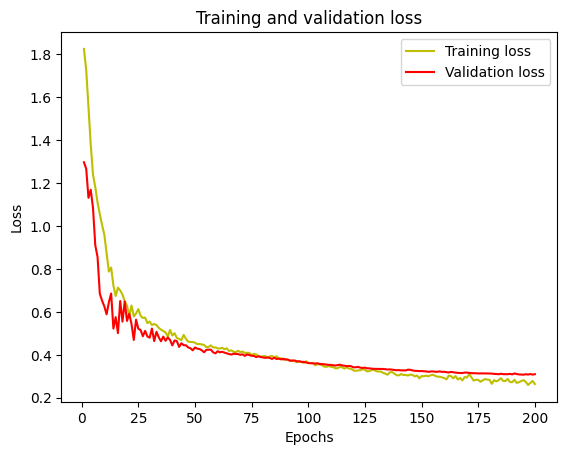

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


*******Test*******
*****oil*****
smape: 3.234
correlation: 0.972
r2 0.945
*****water*****
smape: 43.766
correlation: 0.958
r2 0.915
*****gas*****
smape: 3.266
correlation: 0.972
r2 0.945
*****bhp*****
smape: 1.06
correlation: 0.882
r2 0.769
*******Validation*******
*****oil*****
smape: 3.623
correlation: 0.963
r2 0.926
*****water*****
smape: 42.92
correlation: 0.947
r2 0.893
*****gas*****
smape: 3.708
correlation: 0.963
r2 0.926
*****bhp*****
smape: 1.141
correlation: 0.848
r2 0.719
0 oilO
O


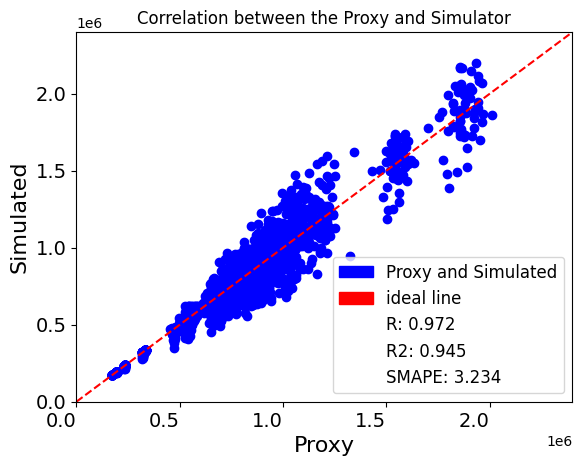

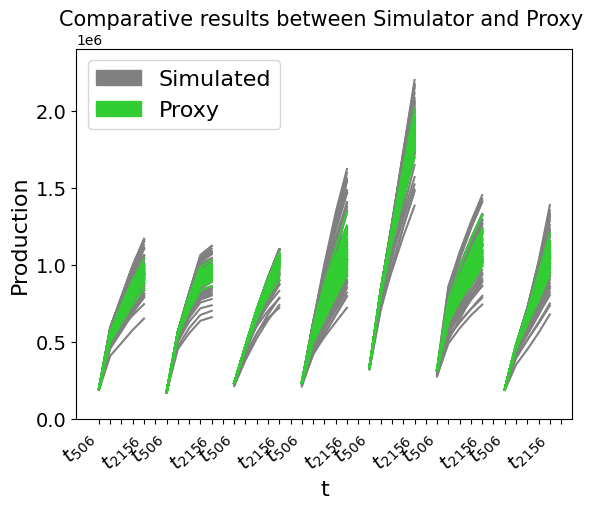

35 waterW
W


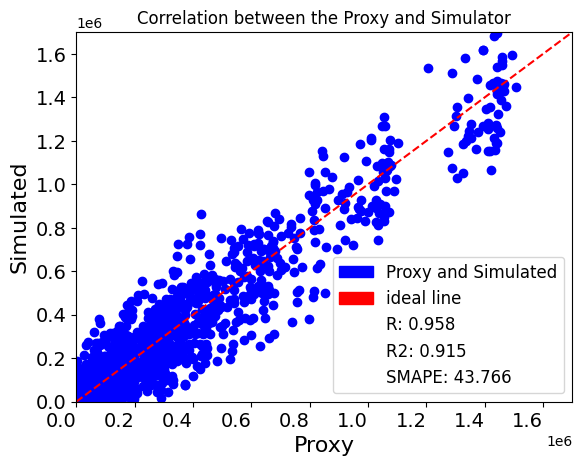

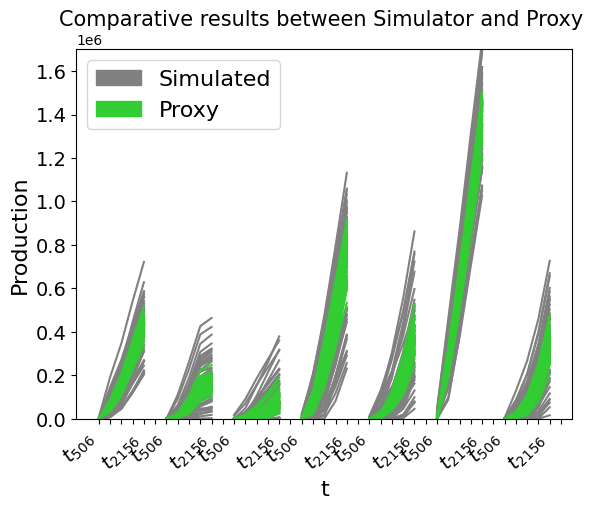

70 gasG
G


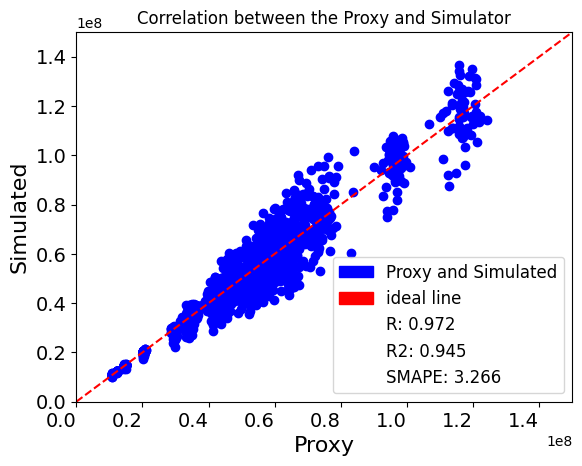

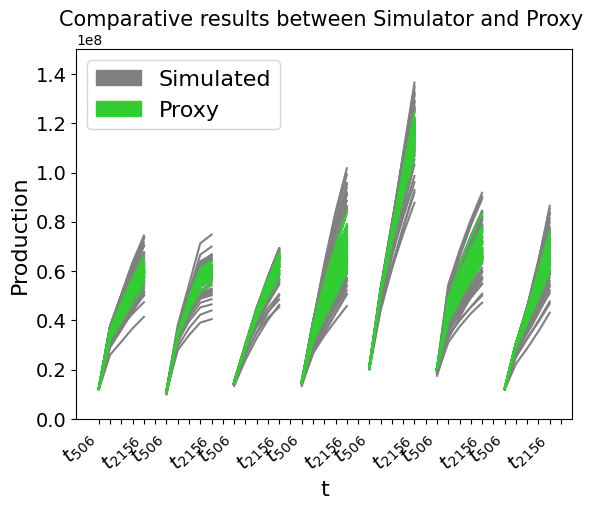

105 bhpB
B


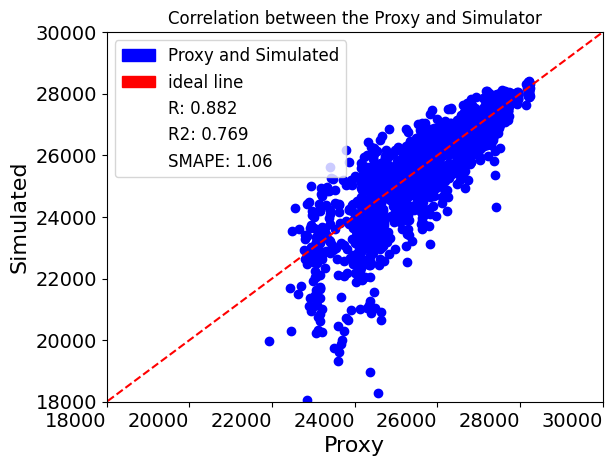

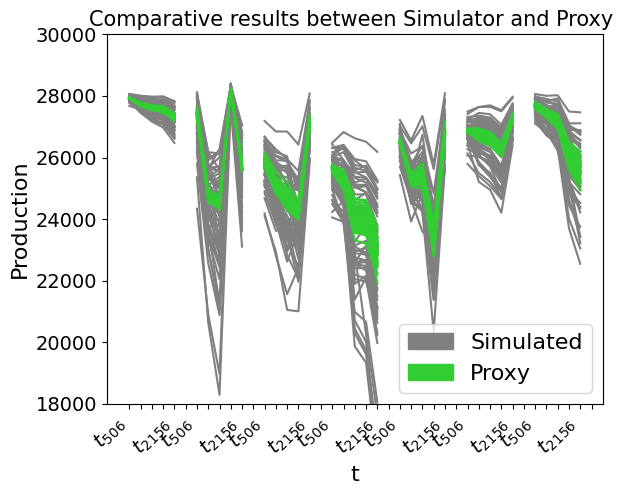

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(60, 1094)
Sensitivity Analysis - Sampler
(1122304, 1094)
Metrics: [0.13474604, 0.18000484, 0.2503405, 0.60642844, 0.79115665]


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [8]:
# Example of how to call the fit function
if __name__ == "__main__":
    uncertainties_path = '/tf/notebooks/jeanfranco/end-to-end/normalization/Uncertainties/'
    production_path = '/tf/notebooks/jeanfranco/end-to-end/normalization/ObjectiveFunction/'
    history_path = '/tf/notebooks/jeanfranco/end-to-end/normalization/Observed/'
    days_txt = '/tf/notebooks/jeanfranco/end-to-end/days.txt'
    gpu_id = 0
    is_some_days = 'someDays'
    results_path = '/tf/notebooks/jeanfranco/end-to-end/Notebooks/3DCNNSave/'
    
    problem, y_test_sobol, x_test_encoder, new_model = pretrained(
        uncertainties_path=uncertainties_path,
        production_path=production_path,
        history_path=history_path,
        days_txt=days_txt,
        gpu_id=gpu_id,
        is_some_days=is_some_days,
        results_path=results_path,
        ann='proxy',
        optimize_analysis=True
    )

In [9]:
from SALib.analyze import sobol as sobol_analyze
import multiprocessing

def perform_sensitivity_analysis(position):
    # Select the desired positions for all rows
    selected_outputs = y_test_sobol[:, position].reshape(-1, 1)
    selected_outputs = np.ravel(selected_outputs)

    # Perform sensitivity analysis using the Sobol' method
    sobol_indices = sobol_analyze.analyze(problem, selected_outputs, calc_second_order=False)

    # Get the first-order and total sensitivity indices
    first_order_indices = sobol_indices['S1']
    total_indices = sobol_indices['ST']

    # Return the indices
    return first_order_indices, total_indices

def perform_parallel_sensitivity_analysis(positions):
    """
    Executes sensitivity analysis in parallel across a range of positions.

    Utilizes all available CPU cores to perform sensitivity analysis for each position
    in the specified range, using a provided sensitivity analysis function.

    Parameters:
    - positions (range): A range of positions for which to perform sensitivity analysis.

    Returns:
    - all_feature_indices (tuple): A tuple containing the first-order sensitivity indices
      for all analyzed positions.
    - all_total_indices (tuple): A tuple containing the total sensitivity indices for
      all analyzed positions.

    """
    with multiprocessing.Pool() as pool:
        results = pool.map(perform_sensitivity_analysis, positions)
    
    all_feature_indices, all_total_indices = zip(*results)
    return all_feature_indices, all_total_indices



position_oleo = range(0, 35)
position_agua = range(35, 70)
position_gas = range(70, 105)
position_bhp = range(105, 140)

# Execute the parallel sensitivity analysis
all_feature_indices, all_total_indices = perform_parallel_sensitivity_analysis(position_oleo)

# Calculate mean indices
mean_feature_indices = np.mean(all_feature_indices, axis=0)
mean_total_indices = np.mean(all_total_indices, axis=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


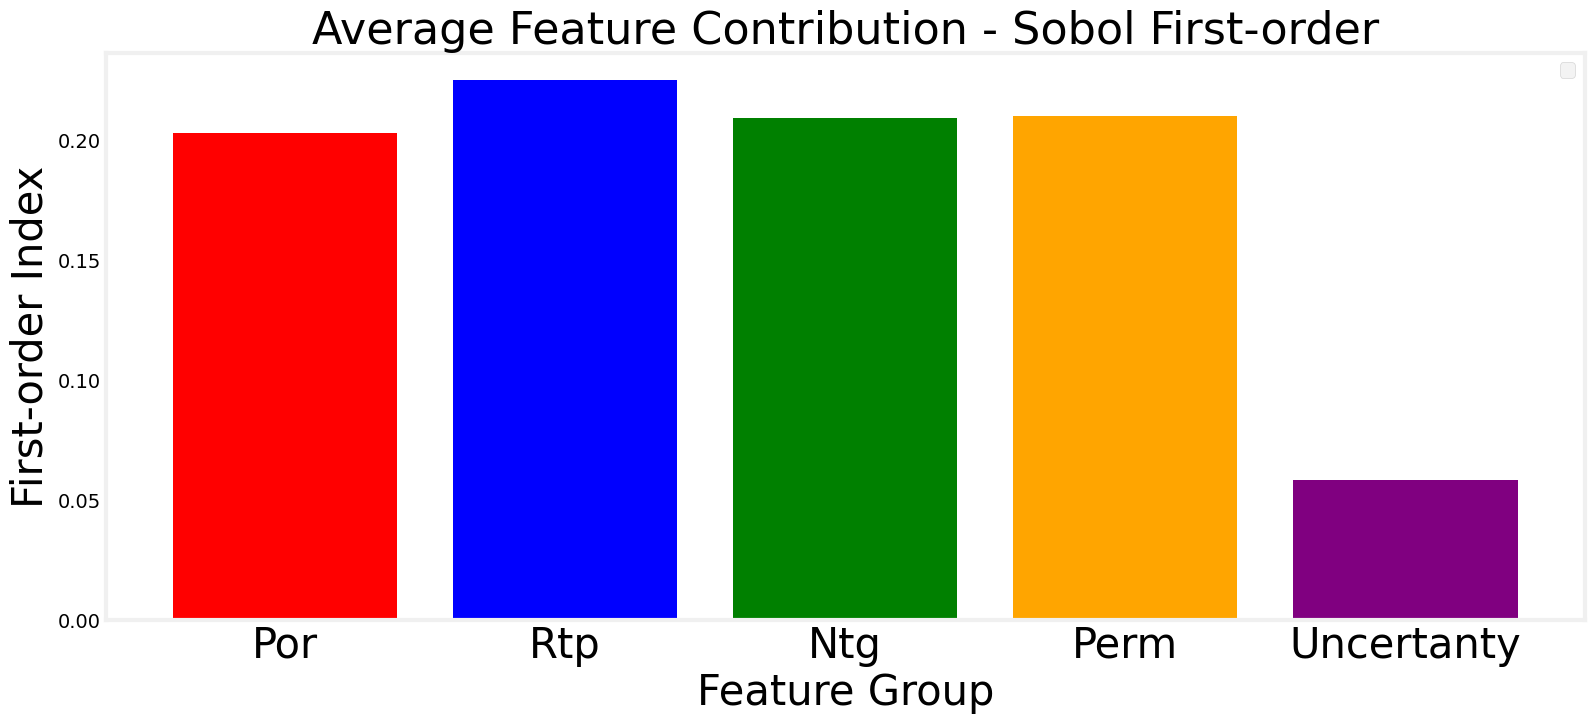

In [10]:
import matplotlib.pyplot as plt
def visualize_average_feature_contributions(mean_feature_indices, filenames):
    """
    Visualizes the average contribution of feature groups based on Sabol first-order indices.

    Parameters:
    - mean_feature_indices (array-like): Array containing mean first-order sensitivity indices.
    - filenames (list of str): Names representing each feature group for labeling purposes.

    The function groups indices into predefined segments, sums their contributions, and
    visualizes these contributions using a bar chart with custom colors for each group.
    """
    groups = aggregate_feature_groups(mean_feature_indices)
    
    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(figsize=(17, 7))
        fig.set_facecolor("w")
        ax.set_facecolor("white")
        bar_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'lime', 'brown']
        ax.bar(filenames, groups, color=bar_colors)
        plt.xticks(fontsize=30)  # Set the fontsize

        ax.set_xlabel('Feature Group', fontsize=30)
        ax.set_ylabel('First-order Index', fontsize=30)
        ax.set_title('Average Feature Contribution - Sobol First-order', fontsize=32)
        ax.legend(title='')
        plt.grid(visible=0)
        plt.show()

def aggregate_feature_groups(mean_feature_indices):
    """
    Aggregates mean feature indices into predefined groups, summing their contributions.

    Parameters:
    - mean_feature_indices (array-like): Array containing mean first-order sensitivity indices.

    Returns:
    - groups (list): List of summed contributions for each predefined feature group.
    """
    groups = []
    # Aggregate contributions for the first 512 indices
    for i in range(0, 1024, 256):
        group_importances = sum(mean_feature_indices[i:i+256])
        groups.append(group_importances)
    
    # Aggregate contributions for the next set of indices
    for i in range(1024, 1094, 70):
        group_importances = sum(mean_feature_indices[i:i+70])
        groups.append(group_importances)
    
    return groups


filenames = ["Por", "Rtp", "Ntg", "Perm", "Uncertanty"]
visualize_average_feature_contributions(mean_feature_indices, filenames)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


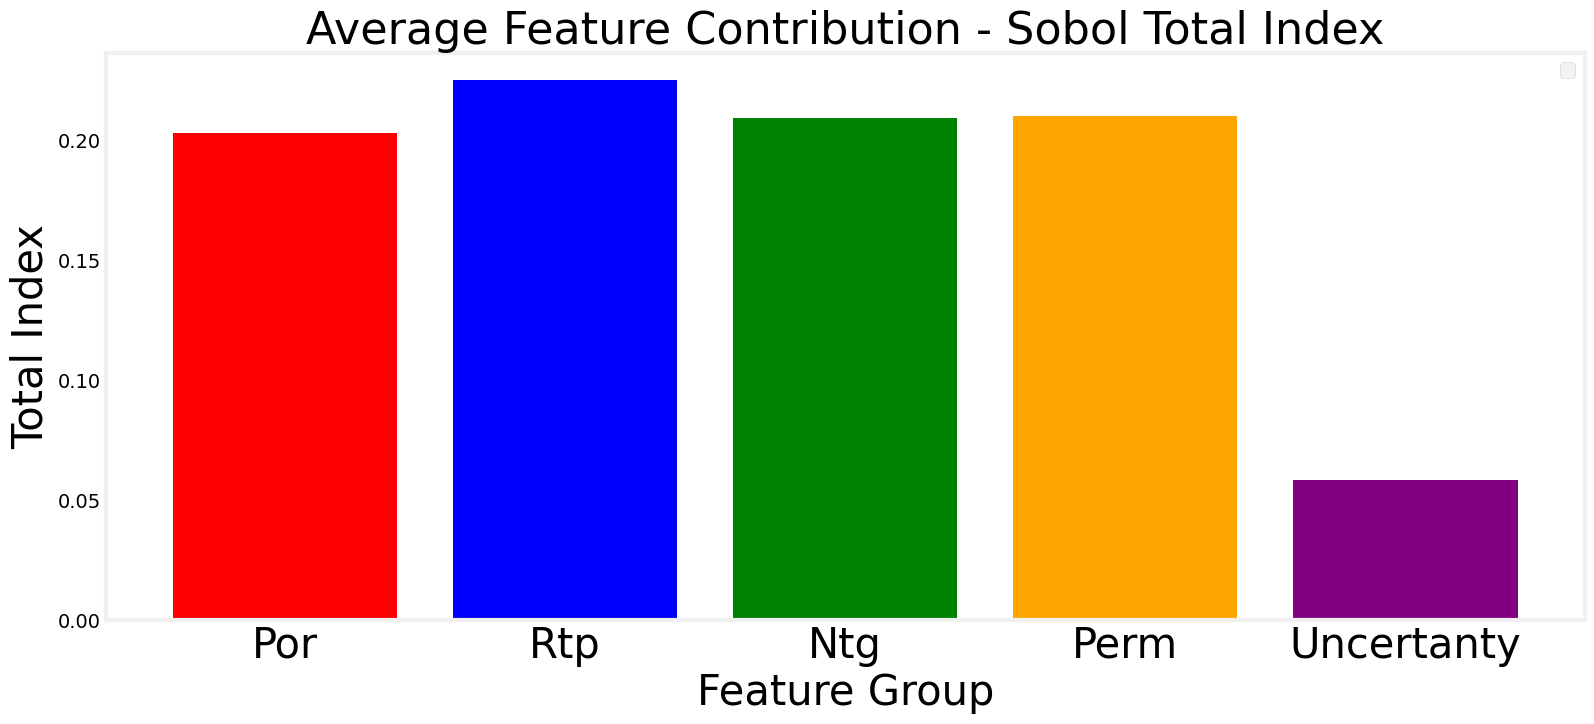

In [11]:
def visualize_average_total_contributions(mean_total_indices, filenames):
    """
    Visualizes the average contribution of feature groups based on Sabol total indices.

    Parameters:
    - mean_total_indices (array-like): Array containing mean total sensitivity indices for features.
    - filenames (list of str): Labels for each feature group, used for the x-axis in the plot.

    This function aggregates total indices into predefined groups and visualizes these
    contributions using a bar chart, applying custom colors to each feature group.
    """
    groups = aggregate_total_groups(mean_total_indices)
    
    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(figsize=(17, 7))
        fig.set_facecolor("w")
        ax.set_facecolor("white")
        bar_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'lime', 'brown']
        ax.bar(filenames, groups, color=bar_colors)
        plt.xticks(fontsize=30)
        ax.set_xlabel('Feature Group', fontsize=30)
        ax.set_ylabel('Total Index', fontsize=30)
        ax.set_title('Average Feature Contribution - Sobol Total Index', fontsize=32)
        ax.legend(title='')
        plt.grid(visible=0)
        plt.show()

def aggregate_total_groups(mean_total_indices):
    """
    Aggregates mean total indices into predefined groups, calculating their summed contributions.

    Parameters:
    - mean_total_indices (array-like): Array of mean total sensitivity indices.

    Returns:
    - groups (list): Summed contributions for each predefined feature group.
    """
    groups = []
    # Aggregate for the first set of indices
    for i in range(0, 1024, 256):
        group_importances = sum(mean_feature_indices[i:i+256])
        groups.append(group_importances)
    
    # Aggregate contributions for the next set of indices
    for i in range(1024, 1094, 70):
        group_importances = sum(mean_feature_indices[i:i+70])
        groups.append(group_importances)
    
    return groups

visualize_average_total_contributions(mean_total_indices, filenames)